# Set model to visualize
After setting these values, just run all cells. Double check data augmentation section.

In [1]:
# Model filename
model_fn = 'ResNet50_v2-fluo-batch16-lr0.1-step1-gamma0.7-epoch45.pt'

model_fn_bf = 'ResNet50_v2-bf-batch16-lr0.1-step1-gamma0.7-epoch45.pt'

### Set batch size and number of GPUs
 

In [2]:
per_device_batch_size = 1
num_gpus = 1
num_workers = 1
batch_size = per_device_batch_size * max(num_gpus, 1)

# Setup



### Import necessary packages

In [3]:
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from google.colab import files, drive   

# Data

### Mount Google Drive

In [4]:
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive/'))

Mounted at /content/gdrive
['cs101', 'Getting started.pdf', 'Colab Notebooks', 'embryo_13_fluo_sequence.mp4', 'embryo_13_fluo_slice.mp4', 'embryo_13_bf_slice.mp4', 'embryo_13_bf_sequence.mp4', 'hi', 'embryo data.gsheet', 'classify_fluo_pretrained.ipynb', 'classify_fluo_CNN_2.ipynb', 'Copy of Pyramid Principle Exercise.gslides', 'dloss_100.npy', 'gloss_100.npy', 'generator_100.pth', 'discriminator_100.pth', 'ResNet50_v2-batch16-lr0.001-mom0.9-wd0.0001 (8)', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch0.params', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch1.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch2.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch3.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch4.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch5.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch6.params', 'ResNet50_v2-batch16-lr0.001-mom0.9-wd0.0001 (7)', 'ResNet50_v2-batch16-lr0.001-mom0

### Define filepaths

In [5]:
home_path = '/content/gdrive/Shared drives/Embryo_data'
processed_path = f'{home_path}/processed'

# Directories for input data
train_path = f'{processed_path}/pix2pix/train/fluo_data'
val_path = f'{processed_path}/pix2pix/val/fluo_data'
test_path = f'{processed_path}/pix2pix/test/fluo_data'

train_path_bf = f'{processed_path}/pix2pix/train/bf_data'
val_path_bf = f'{processed_path}/pix2pix/val/bf_data'
test_path_bf = f'{processed_path}/pix2pix/test/bf_data'

### Data augmentation

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

### Define data loader

In [7]:
class ImageFolderDataset(Dataset):
    """A dataset for loading image files stored in a folder structure.

    like::

        root/car/0001.jpg
        root/car/xxxa.jpg
        root/car/yyyb.jpg
        root/bus/123.jpg
        root/bus/023.jpg
        root/bus/wwww.jpg

    Parameters
    ----------
    root : str
        Path to root directory.
    flag : {0, 1}, default 1
        If 0, always convert loaded images to greyscale (1 channel).
        If 1, always convert loaded images to colored (3 channels).
    transform : callable, default None
        A function that takes data and label and transforms them::

            transform = lambda data, label: (data.astype(np.float32)/255, label)

    Attributes
    ----------
    synsets : list
        List of class names. `synsets[i]` is the name for the integer label `i`
    items : list of tuples
        List of all images in (filename, label) pairs.
    """
    def __init__(self, root, flag=1, transform=None):
        self._root = os.path.expanduser(root)
        self._flag = flag
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        self.items = []

        for filename in sorted(os.listdir(root)):
          filepath = os.path.join(root, filename)
          self.items.append(filepath)

    def __getitem__(self, idx):
        ind = self.items[idx].find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in self.items[idx][ind:-4].split('_')[1:]]
        img = Image.open(self.items[idx]).convert('RGB')
        if self._transform is not None:
            img = self._transform(img)
        return {'img': img, 'label': label, 'embryo_num': embryo_num, 'embryo_t': embryo_t}

    def __len__(self):
        return len(self.items)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

# Fluo
train_dataset = ImageFolderDataset(train_path, transform=transform_train)
val_dataset = ImageFolderDataset(val_path, transform=transform_train)
test_dataset = ImageFolderDataset(test_path, transform=transform_test)

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Bf
train_dataset_bf = ImageFolderDataset(train_path_bf, transform=transform_train)
val_dataset_bf = ImageFolderDataset(val_path_bf, transform=transform_train)
test_dataset_bf = ImageFolderDataset(test_path_bf, transform=transform_test)

train_data_bf = DataLoader(train_dataset_bf, batch_size=batch_size, shuffle=True, **kwargs)
val_data_bf = DataLoader(val_dataset_bf, batch_size=batch_size, shuffle=True, **kwargs)
test_data_bf = DataLoader(test_dataset_bf, batch_size=batch_size, shuffle=False, **kwargs)

# Model


In [129]:
classes = 2

# Fluo
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, classes)
model.to(device)
model_fp = os.path.join(home_path, 'models', 'best', model_fn)
model.load_state_dict(torch.load(model_fp))

# Bf
model_bf = models.resnet50(pretrained=True)
model_bf.fc = torch.nn.Linear(model_bf.fc.in_features, classes)
model_bf.to(device)
model_fp_bf = os.path.join(home_path, 'models', 'best', 'temp-bf.pt')
model_bf.load_state_dict(torch.load(model_fp_bf))

<All keys matched successfully>

### Calculate test accuracy

In [132]:
# define an evaluation function for validation and testing

def test(model, device, test_loader):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data0 in test_loader:
            data = data0['img']
            target = data0['label']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(target)

    test_loss /= total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    return test_loss, correct / total

# # run on test data (fluo)
# _, test_acc = test(model, device, test_data)
# print('[Finished] Test-acc: %.3f' % (test_acc))

# run on test data (bf)
_, test_acc_bf = test(model_bf, device, test_data_bf)
print('[Finished] Test-acc: %.3f' % (test_acc_bf))


Test set: Average loss: 0.5761, Accuracy: 401/449 (89%)

[Finished] Test-acc: 0.893


# Visualize

### Summarize test prediction results

tensor([[ 6.2083, -5.3412]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 2.5929, -1.9634]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.5178, 0.0712]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.3549, 0.1514]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 1.7656, -1.2347]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.6496, -0.1619]], device='cuda:0', grad_fn=<AddmmBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


tensor([[-1.8453,  2.1767]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 2.3288, -1.8093]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 2.2551, -1.6216]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.3971, 0.1086]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.4715, -6.2913]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 6.5311, -5.4600]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.6411, -6.5494]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.8946, -6.7031]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 9.3437, -8.1201]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.1301, -6.0869]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.6011, -6.5206]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.0982, -6.0691]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 6.9357, -5.8771]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 7.0870, -6.0249]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([

Text(0, 0.5, 'Label')

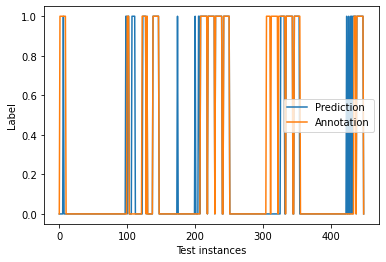

In [134]:
# summarize test prediction results (fluo)
record_pred = []
record_label = []
record_fn = []
for data0 in test_data:
  data = data0['img']
  label = data0['label']
  embryo_num = data0['embryo_num']
  embryo_t = data0['embryo_t']
  data, label, embryo_num, embryo_t = data.to(device), label.to(device), embryo_num.to(device), embryo_t.to(device)
  fp = [os.path.join(test_path, str(label[j].cpu().numpy()), f'embryo_{str(embryo_num[j].cpu().numpy())}_{str(embryo_t[j].cpu().numpy())}.png') for j in range(len(embryo_num))]
  outputs = model(data)
  a = outputs.argmax(dim=1, keepdim=True).cpu().detach().numpy()
  b = label.cpu().detach().numpy()
  if record_pred == []:
    record_pred = a
    record_label = b
    record_fn = fp
  else:
    record_pred = np.concatenate((record_pred, a), axis=0)
    record_label = np.concatenate((record_label, b), axis=0)
    record_fn = np.concatenate((record_fn, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

# summarize test prediction results (bf)
record_pred_bf = []
record_label_bf = []
record_fn_bf = []
for data0 in test_data_bf:
  data = data0['img']
  label = data0['label']
  embryo_num = data0['embryo_num']
  embryo_t = data0['embryo_t']
  data, label, embryo_num, embryo_t = data.to(device), label.to(device), embryo_num.to(device), embryo_t.to(device)
  fp = [os.path.join(test_path_bf, str(label[j].cpu().numpy()), f'embryo_{str(embryo_num[j].cpu().numpy())}_{str(embryo_t[j].cpu().numpy())}.png') for j in range(len(embryo_num))]
  outputs = model_bf(data)
  print(outputs)
  a = outputs.argmax(dim=1, keepdim=True).cpu().detach().numpy()
  b = label.cpu().detach().numpy()
  if record_pred_bf == []:
    record_pred_bf = a
    record_label_bf = b
    record_fn_bf = fp
  else:
    record_pred_bf = np.concatenate((record_pred_bf, a), axis=0)
    record_label_bf = np.concatenate((record_label_bf, b), axis=0)
    record_fn_bf = np.concatenate((record_fn_bf, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred_bf)),record_pred_bf,label='Prediction')
plt.plot(np.arange(len(record_label_bf)),record_label_bf,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

### Confusion matrix

[[307  17]
 [ 31  94]]


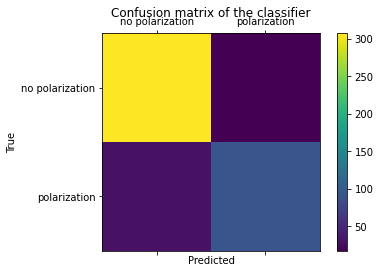

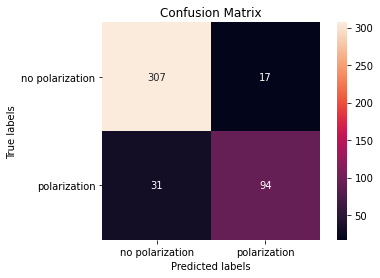

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['no polarization','polarization']
cm = confusion_matrix(record_label_bf, record_pred_bf)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no polarization', 'polarization'])
ax.yaxis.set_ticklabels(['no polarization', 'polarization'], rotation='horizontal')
ax.set_aspect('equal', 'box')

### Attention of CNN

This section refers to https://discuss.mxnet.io/t/how-to-visualize-image-classification-resnetv2/4969

Another similar realization can be seen in https://github.com/nicklhy/CAM/blob/master/cam.ipynb

About Class Activation Maps(CAM):
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [136]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    cam = np.matmul(weight_softmax[idx], feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    return cv2.resize(cam, size_upsample)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps, vmin_lst, vmax_lst):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_images):
        img = images[i]
        vmin = vmin_lst[i]
        vmax = vmax_lst[i]
        axs[i].set_title(titles[i])

        if len(img.shape)==2:
          im = axs[i].imshow(img, cmap=cmaps[i], vmin=vmin, vmax=vmax)
          # create an axes on the right side of ax. The width of cax will be 5%
          # of ax and the padding between cax and ax will be fixed at 0.05 inch.
          divider = make_axes_locatable(axs[i])
          cax = divider.append_axes("right", size="5%", pad=0.05)
          # norm = mpl.colors.Normalize(vmin=-5, vmax=10)
          # cb1 = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.gist_rainbow,
          #                       norm=norm,
          #                       orientation='vertical')
          plt.colorbar(im, cax=cax)
        else:
          im = axs[i].imshow(img, cmap=cmaps[i])
    return fig

In [159]:
def find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name):
  output = finetune_net(test_image)
  classes = ['no polarization','polarization']
  idx = output.argmax(dim=1, keepdim=True)

  features_blob, weight_softmax = find_resnet_features(finetune_net, test_image, model_name)

  CAMs = returnCAM(features_blob, weight_softmax, idx)
  _ , _ , height, width = test_image.shape
  test_CAM = cv2.resize(CAMs,(width, height))
  print('Annotated label: %s'%classes[int(test_label)])
  print('Network prediction: %s'%classes[idx])

  # convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
  test_image_narray = np.swapaxes(np.swapaxes(np.squeeze(test_image.cpu().detach().numpy()),0,2), 0, 1)
  test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)

  test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))

  return test_CAM, test_image_squeeze, idx.cpu().numpy()[0,0]


def find_resnet_features(finetune_net, test_image, model_name):
  if model_name.lower() == 'resnet50_v2':
    params = list(finetune_net.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
    mod = nn.Sequential(*list(finetune_net.children())[:-2]).to(device)
    features_blob = mod(test_image).cpu().detach().numpy()
  else:
    raise Exception('Model name {} not recognized'.format(model_name))
  return features_blob, weight_softmax


def visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst):
  assert(len(test_CAM_lst) == len(test_image_squeeze_lst))
  assert(len(test_CAM_lst) == len(im_type_lst))
  assert(len(test_CAM_lst) == len(fig_title_lst))

  # Find min and max of all images to visualize for color map
  vmin = min([np.min(test_CAM) for test_CAM in test_CAM_lst])
  vmax = max([np.max(test_CAM) for test_CAM in test_CAM_lst])

  for i in range(len(test_CAM_lst)):
    test_CAM = test_CAM_lst[i]
    test_image_squeeze = test_image_squeeze_lst[i]
    im_type = im_type_lst[i]
    fig_title = fig_title_lst[i]
    images = []
    images.append(test_CAM)
    test_image_squeeze_temp = np.zeros((512,512,3))
    for i in range(3):
      test_image_squeeze_temp[:,:,i] = test_image_squeeze
    images.append(test_image_squeeze)

    titles = [fig_title + ' CAM', im_type]
    cmaps = ['seismic', None]
    vmin_lst = [vmin, None]
    vmax_lst = [vmax, None]
    fig = show_images(images, titles, cmaps, vmin_lst, vmax_lst)

#### Specify test image

In [138]:
def find_class(file_path, embryo_num, embryo_t, classes_dirs):
  fn = None
  for cl in classes_dirs:
    fn_new = os.path.join(file_path, f'embryo_{embryo_num}_{embryo_t}_{cl}.png')
    if os.path.isfile(fn_new):
      return cl
  return

Annotated label: polarization
Network prediction: polarization
Annotated label: polarization
Network prediction: polarization
Annotated label: polarization
Network prediction: polarization


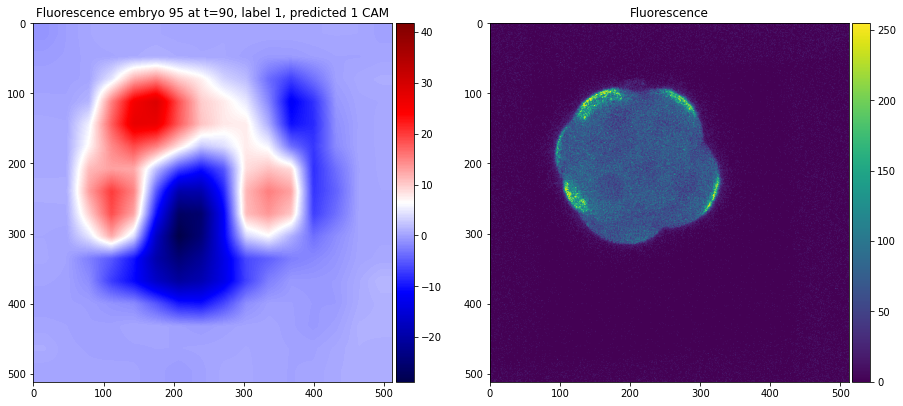

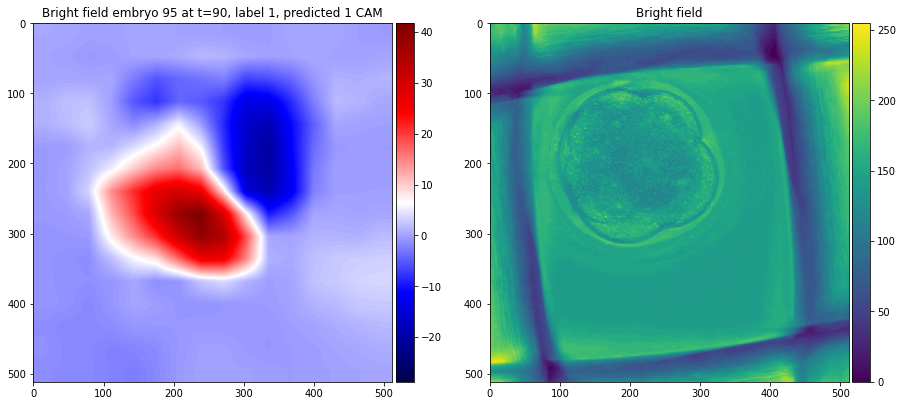

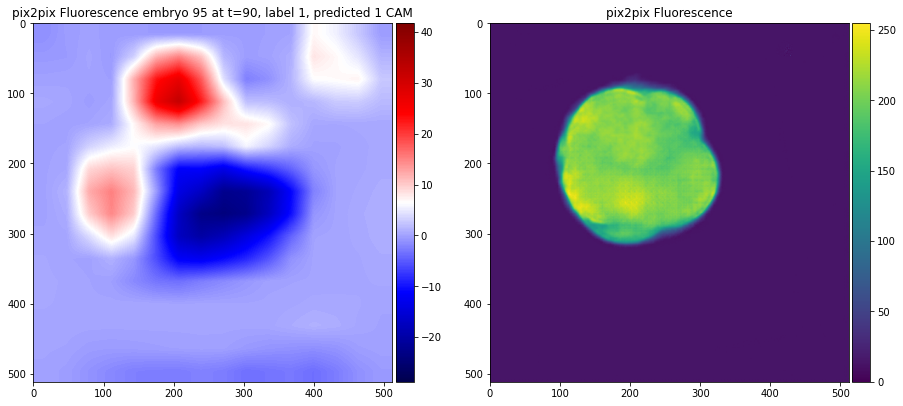

In [171]:
classes_dirs = ['0', '1']

embryo_num_lst = [95]
embryo_t_lst = [90]
model_name = 'resnet50_v2'


test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst = [], [], [], []
for i in range(len(embryo_num_lst)):
  embryo_num = embryo_num_lst[i]
  embryo_t = embryo_t_lst[i]

  # Fluo
  im_type = 'Fluorescence'
  test_label = find_class(test_path, embryo_num, embryo_t, classes_dirs)
  test_image_fn = os.path.join(test_path, f'embryo_{embryo_num}_{embryo_t}_{test_label}.png')
  test_image = torch.unsqueeze(transform_test(Image.open(test_image_fn).convert('RGB')), 0).to(device)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(model, test_image, test_label, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t}, label {test_label}, predicted {test_annot}'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)

  # Bright field
  im_type = 'Bright field'
  test_label_bf = find_class(test_path_bf, embryo_num, embryo_t, classes_dirs)
  test_image_fn_bf = os.path.join(test_path_bf, f'embryo_{embryo_num}_{embryo_t}_{test_label_bf}.png')
  test_image_bf = torch.unsqueeze(transform_test(Image.open(test_image_fn_bf).convert('RGB')), 0).to(device)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(model_bf, test_image_bf, test_label_bf, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t}, label {test_label_bf}, predicted {test_annot}'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)

  # Fluo
  im_type = 'pix2pix Fluorescence'
  test_label = find_class(test_path_bf, embryo_num, embryo_t, classes_dirs)
  test_image_fn = os.path.join(test_path_bf, f'embryo_{embryo_num}_{embryo_t}_{test_label}.png')
  test_image_temp = torch.unsqueeze(transform_test(Image.open(test_image_fn)), 0).to(device)
  test_image0 = generator(test_image_temp)
  test_image = torch.empty((1,3,512,512)).to(device)
  for i in range(3):
      test_image[0,i,:,:] = test_image0

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(model, test_image, test_label, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t}, label {test_label}, predicted {test_annot}'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)


visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst)

#### pix2pix Analysis

In [53]:
import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.files = sorted(glob.glob(os.path.join(root, mode, 'fluo_data') + "/*.*"))

    def __getitem__(self, index):
        fn_fluo = self.files[index % len(self.files)]
        fn_bf = fn_fluo.replace('fluo_data', 'bf_data')

        img_fluo = Image.open(fn_fluo)
        img_bf = Image.open(fn_bf)
        img_fluo = self.transform(img_fluo)
        img_bf = self.transform(img_bf)

        ind = fn_fluo.find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in fn_fluo[ind:-4].split('_')[1:]]

        return {"bf": img_bf, "fluo": img_fluo, "embryo_num": embryo_num, "embryo_t": embryo_t, "label": label}

    def __len__(self):
        return len(self.files)

In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [55]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [56]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [57]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [58]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.models as models

torch.manual_seed(42)
np.random.seed(42)

In [167]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

class Args():
  def __init__(self, epoch=20, n_epochs=200, dataset_name='data', batch_size=1,
          lr=0.0002, b1=0.5, b2=0.999, decay_epoch=100, n_cpu=8,
          img_height=512, img_width=512, channels=1,
          sample_interval=500, checkpoint_interval=10
          ):
      self.epoch = epoch # epoch to start training from
      self.n_epochs = n_epochs # number of epochs of training
      self.dataset_name = dataset_name # name of the dataset
      self.batch_size = batch_size # size of the batches
      self.lr = lr # adam: learning rate
      self.b1 = b1 # adam: decay of first order momentum of gradient
      self.b2 = b2 # adam: decay of second order momentum of gradient
      self.decay_epoch = decay_epoch # epoch from which to start lr decay
      self.n_cpu = n_cpu # number of cpu threads to use during batch generation
      self.img_height = img_height # size of image height
      self.img_width = img_width # size of image width
      self.channels = channels # number of image channels
      self.sample_interval = sample_interval # interval between sampling of images from generators
      self.checkpoint_interval = checkpoint_interval # interval between model checkpoints

opt = Args(dataset_name="pix2pix-normal-loss")

os.makedirs(f"{home_path}/images/{opt.dataset_name}", exist_ok=True)
os.makedirs(f"{home_path}/models/{opt.dataset_name}", exist_ok=True)

cuda = True if torch.cuda.is_available() else False
print(cuda)

True


In [168]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()
criterion_polarity = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 1000
lambda_polarity = 750

# Calculate output of image discriminator (PatchGAN)
patch = (1, opt.img_height // 2 ** 4, opt.img_width // 2 ** 4)

In [169]:
# Initialize generator and discriminator
generator = GeneratorUNet(in_channels=1, out_channels=1)
discriminator = Discriminator(in_channels=1)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load(f"{home_path}/models/{opt.dataset_name}/generator_{opt.epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"{home_path}/models/{opt.dataset_name}/discriminator_{opt.epoch}.pth"))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

#### Correct prediction

In [ ]:
group_id = 5 #3
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break

In [ ]:
# get an image
test_idx = 0 #15
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
print(test_image.shape, type(test_image))

(1, 3, 512, 512) <class 'mxnet.ndarray.ndarray.NDArray'>


Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


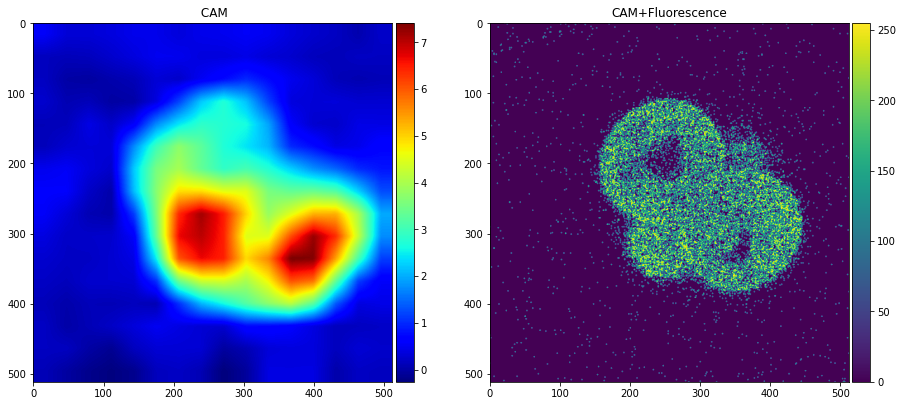

In [ ]:
test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
visualize_CAM_and_fluo_data([test_CAM], [test_image_squeeze], ['Fluorescence'], [''])

#### Wrong prediction

In [157]:
tp = record_pred==record_label

itemindex = np.where(tp==True)
print(record_fn[2])

/content/gdrive/Shared drives/Embryo_data/processed/pix2pix/test/fluo_data/1/embryo_102_101.png


In [ ]:
FN_idx = 1
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)

Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


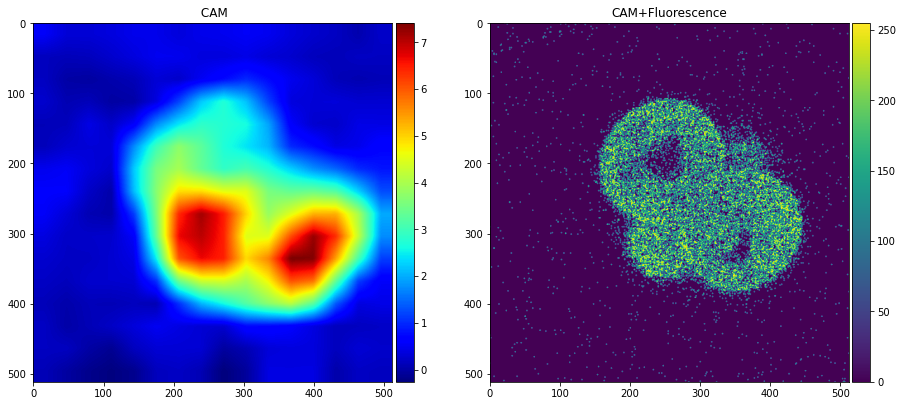

In [ ]:
test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
visualize_CAM_and_fluo_data([test_CAM], [test_image_squeeze], ['Fluorescence'], [''])

In [ ]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)


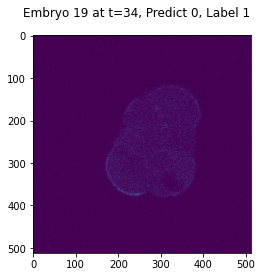

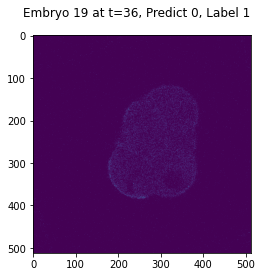

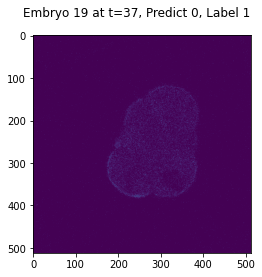

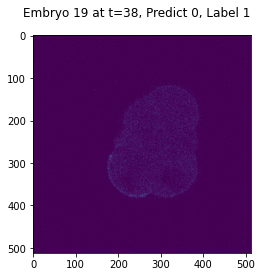

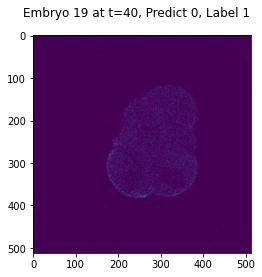

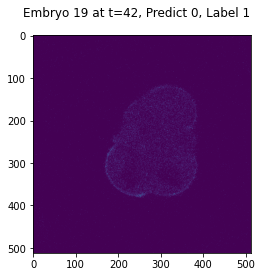

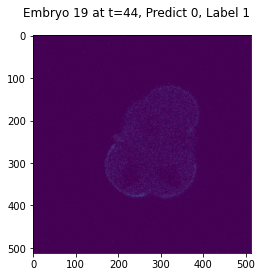

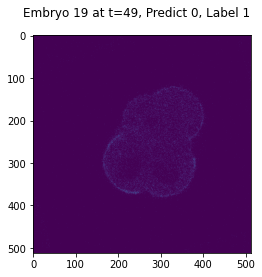

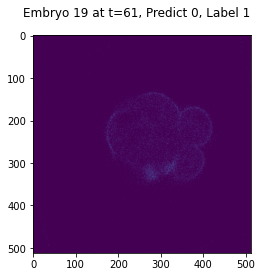

In [ ]:
for FN_idx in range(len(itemindex[0])):
  group_id = np.floor(itemindex[0][FN_idx]/batch_size)
  for i, batch in enumerate(test_data):
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      if i == group_id:
        break
  test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
  fn = record_fn[int(group_id)]
  im = Image.open(fn)
  fig = plt.figure()
  fn_lst = fn[:-4].split('_')
  embryo_num = int(fn_lst[-2])
  embryo_t = int(fn_lst[-1])
  fig.suptitle(f'Embryo {embryo_num} at t={embryo_t}, Predict {record_pred[int(group_id)]}, Label {record_label[int(group_id)]}')
  plt.imshow(im, vmin=0, vmax=255)

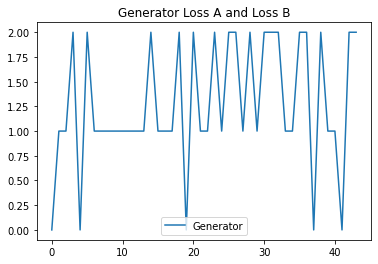

In [192]:
gloss_fn = f'{home_path}/models/pix2pix-polarity-loss/gloss_polarity_10.npy'
# gloss_fn2 = f'{home_path}/models/pix2pix-polarity-loss/gloss_GAN_10.npy'
# dloss_fn = f'{home_path}/models/pix2pix-polarity-loss/dloss_10.npy'

glosss1 = list(np.load(gloss_fn)) + list(np.load(gloss_fn.replace('10', '20')))
# glosss2 = list(np.load(gloss_fn2)) + list(np.load(gloss_fn2.replace('10', '20')))
glosss = glosss1
# dlosss = list(np.load(dloss_fn)) + list(np.load(dloss_fn.replace('10', '20')))

plt.plot(glosss[0:-1:918], label='Generator')
# plt.plot(dlosss[0:-1:918], label='Discriminator')
plt.title('Generator Loss A and Loss B')
plt.legend()
plt.show()